In [16]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [362]:
from argparse import ArgumentParser
from pathlib import Path
import typing as tp

import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ml_collections import ConfigDict

%autoreload 2
from train_with_stylegan.trainer import DIffGANTrainer
from train_with_stylegan.utils import configure_unet_model_from_pretrained
from train_with_stylegan.train import load_params, configure_checkpoint_path

In [254]:
device = torch.device(f"{args.device}") if torch.cuda.is_available else torch.device("cpu")
teacher = configure_unet_model_from_pretrained(args.teacher)
student = configure_unet_model_from_pretrained(args.teacher)

teacher.to(device)
student.to(device)

teacher.eval()
student.train()

log_dir, last_ckpt = configure_checkpoint_path(args)

### Config from diffusers

In [116]:
from diffusers import DDPMPipeline

In [117]:
ddpm_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")

In [118]:
ddpm_pipeline.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.18.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_large"
}

### Sample Images

In [369]:
args = dict(
    name="student",
    teacher="google/ddpm-cifar10-32",
    params=Path("./train_with_stylegan/params/boot.yaml"),
    device="cpu",
    project="boot",
    dir=Path("boot-ckpt")
)
args = ConfigDict(args)
params = load_params(args)

In [363]:
# Run if you want discrete sampler
params.training.continuous = False
params.training.beta_min = 0.0001
params.training.beta_max = 0.02

In [370]:
trainer = DIffGANTrainer(
    teacher=teacher,
    student=student,
    params=params,
    device=device,
    log_dir=log_dir,
)

print(params.training.continuous)
print(params.training.beta_max)
print(params.training.beta_min)

True
20.0
0.1


In [371]:
images = trainer.sample_with_teacher(1)

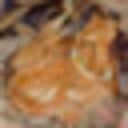

In [372]:
idx = 0
Image.fromarray(np.uint8(images.permute(0, 2, 3, 1).numpy()[idx] * 255)).resize((128,128), Image.BICUBIC)

### Experiments with functions

In [379]:
images.mul(255).numpy().astype(np.uint8())

array([[[[122,  65,  44, ..., 159, 153, 156],
         [112,  57,  45, ..., 166, 168, 160],
         [ 98,  69,  64, ..., 153, 160, 155],
         ...,
         [176, 154, 145, ..., 132, 154, 177],
         [199, 182, 167, ..., 141, 176, 184],
         [202, 193, 188, ..., 143, 184, 189]],

        [[108,  57,  36, ..., 124, 117, 121],
         [ 97,  45,  35, ..., 143, 140, 140],
         [ 78,  49,  46, ..., 131, 135, 134],
         ...,
         [152, 130, 122, ..., 101, 114, 157],
         [174, 158, 142, ..., 102, 128, 151],
         [176, 165, 162, ..., 103, 126, 145]],

        [[ 96,  63,  48, ..., 103, 100,  99],
         [ 92,  60,  47, ..., 117, 112, 112],
         [ 81,  52,  42, ..., 107, 112, 113],
         ...,
         [127, 105,  93, ...,  79,  97, 137],
         [144, 130, 113, ...,  81, 112, 134],
         [142, 133, 134, ...,  81, 114, 136]]]], dtype=uint8)

In [121]:
T = 1000
betas = np.linspace(0.0001, 0.02, T, dtype=np.float64)
self_alphas_cumprod = np.cumprod(1 - betas)

t = 34

alpha_prod_t = self_alphas_cumprod[t]
beta_prod_t = 1 - alpha_prod_t

sigma_fn(torch.tensor(t / T)), beta_prod_t**0.5

(tensor(0.1216), 0.12344683312338371)

In [122]:
alpha_prod_t ** 0.5, alpha_fn(torch.tensor(t / T))

(0.9923511875298016, tensor(0.9926))

In [117]:
T = 1000
betas = np.linspace(0.0001, 0.02, T, dtype=np.float64)
self_alphas_cumprod = np.cumprod(1 - betas)


x_0_coeff = []
x_t_coeff = []
x_0_coeff_c = []
x_t_coeff_c = []
prev_t = -1
for t in range(T):
    alpha_prod_t = self_alphas_cumprod[t]
    alpha_prod_t_prev = self_alphas_cumprod[prev_t] if prev_t >= 0 else 1
    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t
    
    pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t
    x_0_coeff.append(pred_original_sample_coeff)
    x_t_coeff.append(current_sample_coeff)
    prev_t = t
    
    t = torch.ones(1) * t
    t_tilda = torch.maximum(t / 1000, torch.tensor(1e-6))
    t_prev_tilda = torch.maximum((t - 1) / 1000, torch.tensor(1e-6))

    alpha_t = alpha_fn(t_tilda).numpy()[0]
    alpha_prev = alpha_fn(t_prev_tilda).numpy()[0]
    if alpha_t == alpha_prev:
        alpha_prev = 1

    sigma_t = sigma_fn(t_tilda).numpy()[0]
    sigma_prev = sigma_fn(t_prev_tilda).numpy()[0]
    if sigma_t == sigma_prev:
        sigma_prev = 0
    
    pred_original_sample_coeff = (alpha_prev / sigma_t ** 2) * (1 - (alpha_t / alpha_prev) ** 2)
    current_sample_coeff = np.sqrt(alpha_t / alpha_prev) * ((sigma_prev / sigma_t) ** 2)
    x_0_coeff_c.append(pred_original_sample_coeff)
    x_t_coeff_c.append(current_sample_coeff)
    
# x_0_coeff_c =  np.array(x_0_coeff_c).flatten()
# x_0_coeff_c[0] = 1
# x_t_coeff_c =  np.array(x_t_coeff_c).flatten()
# x_t_coeff_c[0] = 0

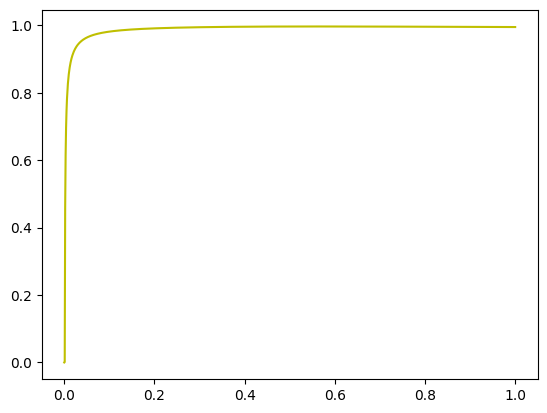

In [119]:
t = np.linspace(0, 1, T)
# plt.plot(t, np.array(x_0_coeff), c="r")
# plt.plot(t, x_t_coeff, c="b")
# plt.plot(t, np.array(x_0_coeff_c), c="g")
plt.plot(t, x_t_coeff_c, c="y")
plt.show()

In [40]:
alpha_fn = trainer._diffusion_scheduler._alpha_fn
sigma_fn = trainer._diffusion_scheduler._sigma_fn

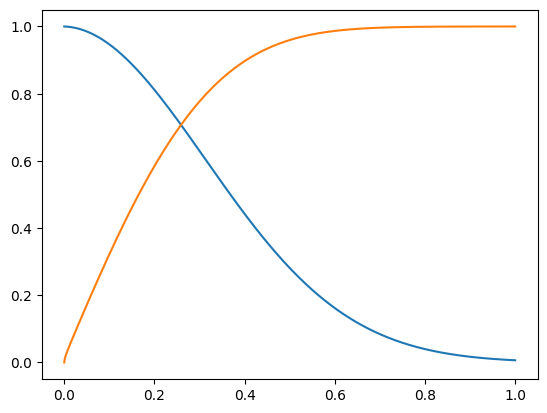

In [41]:
t = np.linspace(0, 1, 1000)
plt.plot(t, alpha_fn(torch.from_numpy(t)).numpy())
plt.plot(t, sigma_fn(torch.from_numpy(t)).numpy())
plt.show()

In [15]:
images = trainer.sample_with_teacher(2)

In [9]:
img = images.permute(0, 2, 3, 1).detach().numpy()
img.shape

(1, 32, 32, 3)

In [10]:
img[0].shape

(32, 32, 3)

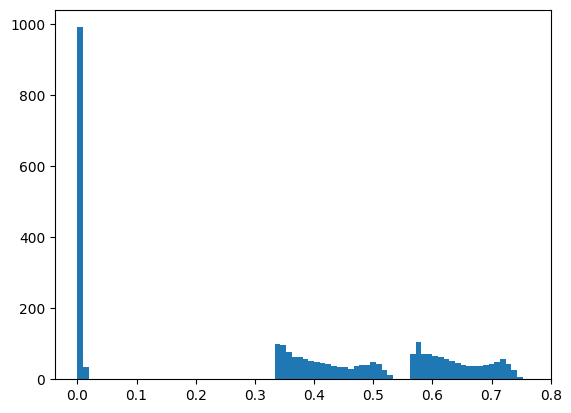

In [11]:
plt.hist(img.reshape(-1), bins=80)
plt.show()

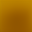

In [12]:
img = images.permute(0, 2, 3, 1).detach().numpy()
Image.fromarray(np.uint8(img[0] * 255))

In [13]:
np.uint8(img[0] * 255)

array([[[190, 138,   2],
        [189, 134,   3],
        [188, 134,   2],
        ...,
        [189, 133,   1],
        [190, 134,   1],
        [194, 135,   3]],

       [[188, 135,   0],
        [186, 132,   3],
        [186, 132,   1],
        ...,
        [187, 131,   0],
        [188, 132,   0],
        [190, 134,   1]],

       [[187, 135,   1],
        [186, 132,   3],
        [185, 131,   2],
        ...,
        [186, 130,   1],
        [188, 131,   1],
        [190, 132,   2]],

       ...,

       [[157, 103,   0],
        [158, 101,   2],
        [156,  99,   1],
        ...,
        [155,  97,   0],
        [157,  98,   0],
        [160, 102,   1]],

       [[157, 102,   1],
        [158, 101,   3],
        [156,  99,   2],
        ...,
        [155,  97,   1],
        [156,  98,   0],
        [160, 102,   1]],

       [[154, 100,   2],
        [155,  99,   4],
        [153,  96,   3],
        ...,
        [153,  96,   2],
        [154,  97,   1],
        [157, 100,   2]]